# Batch forecasting on Ray Tune

Batch training and tuning are common tasks in simple machine learning use-cases such as time series forecasting. They require fitting of simple models on multiple data batches corresponding to locations, products, etc.

**'Batch training'** is a workload that trains model(s) on subsets of a dataset. This notebook showcases how to conduct batch training using [Ray Tune](https://docs.ray.io/en/latest/tune/index.html).

![Batch training diagram](../../data/examples/images/batch-training.svg)

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

In this notebook, we will split the data by pickup location and train a separate forecasting model to predict #pickups at each location in NYC at monthly level for the next 2 months. Specifically, we will use the `pickup_location_id` column in the dataset to group the dataset into data batches. Then we will fit a separate model for each batch and evaluate it.

# Contents

In this this tutorial, you will learn about:
 1. [Define how to load and prepare Parquet data](#prepare_data)
 2. [Define your Ray Tune Search Space and Search Algorithm](#define_search_space2)
 3. [Define a Trainable (callable) function](#define_trainable2)
 4. [Run batch training on Ray Tune](#run_tune_search2)
 5. [Load a model from checkpoint and perform inference](#load_checkpoint2)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](https://docs.ray.io/en/latest/tune/key-concepts.html) page for Ray Tune.
```

Let us start by importing a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [1]:
import os
print(f'Number of CPUs in this system: {os.cpu_count()}')
from typing import Tuple, List, Union, Optional, Callable
from datetime import datetime
import time
import pandas as pd
import numpy as np
print(f"numpy: {np.__version__}")
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
print(f"scipy: {scipy.__version__}")
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds
print(f"pyarrow: {pyarrow.__version__}")

Number of CPUs in this system: 8
numpy: 1.23.4
scipy: 1.9.3
pyarrow: 10.0.0


In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2022-11-19 10:33:35,758	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-11-19 10:33:35,759	INFO worker.py:1342 -- Connecting to existing Ray cluster at address: 172.31.248.159:9031...
2022-11-19 10:33:35,792	INFO worker.py:1519 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard 


Python version:,3.8.13
Ray version:,2.1.0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard


In [3]:
print(ray.cluster_resources())

{'object_store_memory': 27553372569.0, 'memory': 66320763290.0, 'CPU': 24.0, 'node:172.31.248.159': 1.0, 'node:172.31.155.236': 1.0}


In [4]:
# import forecasting libraries
import statsmodels
print(f"statsmodels: {statsmodels.__version__}")
import prophet
from prophet import Prophet
print(f"prophet: {prophet.__version__}")
# Open-source ARIMA forecasting libraries
import pmdarima
from pmdarima.model_selection import train_test_split
print(f"arima: {pmdarima.__version__}")

# import ray libraries
from ray import air, tune
from ray.air import session
from ray.air.checkpoint import Checkpoint

# set global random seed for sklearn models
np.random.seed(415)

statsmodels: 0.13.5
prophet: 1.1.1
arima: 2.0.1


In [5]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False

def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)
        
# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = False


## Define how to load and prepare Parquet data <a class="anchor" id="load_data"></a>

First, we need to load some data.  Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adpater is faster than pandas read_parquet, even using engine=pyarrow.
```

In [6]:
# Define some global variables.
TARGET = "trip_duration"
FORECAST_LENGTH = 28
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

# Obtain all location IDs
all_location_ids = (
    pq.read_table(s3_files[0], columns=["pickup_location_id"])["pickup_location_id"]
    .unique()
    .to_pylist()
)
# drop [264, 265]
all_location_ids.remove(264)
all_location_ids.remove(265)

# Use smoke testing or not.
starting_idx = -6 if SMOKE_TEST else 0
#TODO - drop error-handling test in SMOKE_TEST location 199 
sample_locations = [1, 141, 199] if SMOKE_TEST else all_location_ids

# Display what data will be used.
s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")

NYC Taxi using 18 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 's3://anonymous@air-example-data/ursa-

In [7]:
# Function to read a pyarrow.Table object using pyarrow parquet 
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:
    
    # parse out min expected date
    part_zero = 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/'
    split_text = file.split(part_zero)[1]
    min_year = split_text.split('/')[0]
    min_month = split_text.split('/')[1]
    string_date = min_year + "-" + min_month + "-" + "01" + " 00:00:00"
    min_date = datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S")
    
    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">=", min_date),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]), 
            ("pickup_location_id", "=", sample_id)
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df

# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    
    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]
    
    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    
    # add year_month_day and concat into a unique column to use as groupby key
    df['ds'] = df['pickup_at'].dt.to_period('D').dt.to_timestamp()
    df['loc_year_month_day'] = df['pickup_location_id'].astype(str) + "_"  + \
                            df["pickup_at"].dt.year.astype(str) + "_"  + \
                            df["pickup_at"].dt.month.astype(str) + "_"  + \
                            df["pickup_at"].dt.day.astype(str)
    # add target_value quantity for groupby count later
    df['y'] = 1
    # drop unnecessary columns
    df.drop(["dropoff_at", "pickup_at", "dropoff_location_id", "fare_amount",
            "pickup_location_id", "passenger_count", "trip_distance", "trip_duration"]
            , axis=1, inplace=True)
#     return df
    
    # groupby aggregregate
    g = df.groupby("loc_year_month_day")\
                .agg({'ds': min,
                      'y': sum})
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g['y'] > 2].copy()
    
    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)
    
    return g

In [8]:
# %%time

# # Test reading data pandas.
# sample_location_id = 1
# df_list = [read_data(f, sample_location_id) for f in s3_files] 
# [print(i.shape) for i in df_list]
# df_raw = pd.concat(df_list, ignore_index=True)

# # Abort if df has fewer than 3 * FORECAST_LENGTH
# if df_raw.shape[0] < FORECAST_LENGTH * 3:
#     print(f"ERROR df_raw has {df_raw.shape[0]}")
# else:
#     df = transform_df(df_raw)
    
# print(df.shape)
# print(df.sample(5))
# # check null values
# print("Checking for null values...")
# print(df.info())
# # check ranges
# print("Checking ranges make sure y has at least 2 data points...")
# df.describe(include='all', datetime_is_numeric=True)


# # All data 18 files, with pandas groupby monthly, forecast 6 months
# # CPU times: user 35.8 s, sys: 16 s, total: 51.8 s
# # Wall time: 1min 1s

# # 6 files, with pandas groupby daily, forecast next 28 days
# # CPU times: user 11.7 s, sys: 5.43 s, total: 17.1 s
# # Wall time: 16.4 s

# # 3 files, with pandas groupby daily, forecast next 28 days
# # CPU times: user 5.84 s, sys: 2.36 s, total: 8.2 s
# # Wall time: 6.51 s

In [9]:
# # plot a timeseries
# plt.figure(figsize=(8, 5))
# ax = plt.gca()
# df.plot(x="ds", y="y", ax=ax, label=f"pickup_location_id={sample_location_id}");

# # example location = 1 is a sparse dataset, this is usually very hard to predict!

## Define your Ray Tune Search Space and Search Algorithm <a class="anchor" id="define_search_space"></a>

In this notebook, we will use Ray Tune to run parallel training jobs per pickup location.  The training jobs will be defined using a search space and simple grid search.  Depending on your need, fancier search spaces and search algorithms are possible with Tune. 

**First, define a search space of experiment trials to run.**  
> The typical use case for Tune search spaces are for hypterparameter tuning.  In our case, we are defining a Tune search space in a way to allow for training jobs to be conducted automatically.  Each training job will run on a different data partition (taxi pickup location) and use a different model.

Common search algorithms include grid search, random search, and Bayesian optimization.  For more details, see [Working with Tune Search Spaces](https://docs.ray.io/en/master/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial).  Deciding the best combination of search space and search algorithm is part of the art of being a Data Scientist and depends on the data, algorithm, and problem being solved!  

**Next, define a search algorithm.**
>Ray Tune will use the search space and the specified search algorithm to generate multiple configurations, each of which will be evaluated in a separate Trial on a Ray Cluster. Ray Tune will take care of orchestrating those Trials automatically.  Specifically, Ray Tune will pass a config dictionary to each partition and make a Trainable function call.

**Below, we define our search space consists of:**
- Prophet seasonality parameters 
- Some or all NYC taxi drop-off locations. 

**Also below, we define our search algorithm is:**
- Grid search.

What this means is every algorithm will be applied to every NYC Taxi drop-off location.

In [10]:
# 1. Define a search space.
search_space = {
    "model_type": tune.grid_search(["prophet_additive", "prophet_multiplicative", "arima"]),
    "location": tune.grid_search(sample_locations),
}

## Define a Trainable (callable) function <a class="anchor" id="define_trainable"></a>

📈 Typically when you are running Data Science experiments, you want to be able to keep track of summary metrics for each trial, so you can decide at the end which trials were best.  That way, you can decide which model to deploy.

🇫 Next, we define a trainable function in order to train and evaluate a Prophet model on a data partition.  This function will be called in parallel by every Tune trial.  Inside this trainable function, we will:
- Add detailed metrics we want to report (each model's loss or error). 
- Checkpoint each model for easy deployment later.

📖 **The metrics defined inside the trainable function will appear in the Ray Tune experiment summary table.**
```{tip}
Ray Tune has two ways of defining a trainable, namely the [Function API](https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs) and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

**In the cell below, we define a "Trainable" function called `train_model()`**.  
- The input is a config dictionary argument. 
- The output can be a simple dictionary of metrics which will be reported back to Tune.  
- We will [checkpoint](https://docs.ray.io/en/master/ray-air/key-concepts.html#checkpoints) save each model in addition to reporting each trial's metrics.
- Since we are using **grid search**, this means `train_model()` will be run *in parallel for every permutation* in the Tune search space!

In [11]:
def evaluate_model_prophet(model: 'prophet.forecaster.Prophet')
-> Tuple[float, pd.DataFrame]:

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(periods=FORECAST_LENGTH, freq='D')
    future = model.predict(future_dates)

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp['forecast_error'] = np.abs(temp['yhat'] - temp['trend'])
    error = np.mean(temp['forecast_error'])

    return error, future

def evaluate_model_arima(model: 'pmdarima.arima.arima.ARIMA', test_df: pd.DataFrame)
-> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecast = pd.DataFrame(model.predict(n_periods=FORECAST_LENGTH, index=test_df.index))
    forecast.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    future = pd.concat([test_df, forecast], axis=1)
    future.columns = ['trend', 'yhat']

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp['forecast_error'] = np.abs(temp['yhat'] - temp['trend'])
    error = np.mean(temp['forecast_error'])

    return error, future

# 2. Define a custom train function
def train_model(config: dict) -> None:

    # Get Tune parameters
    sample_location_id = config['location']
    model_type = config['model_type']
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    # Define Prophet model with 75% confidence interval
    if model_type == "prophet_additive":
        model = Prophet(interval_width=0.75, seasonality_mode="additive")
    elif model_type == "prophet_multiplicative":
        model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")
    
    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]   
    df_raw = pd.concat(df_list, ignore_index=True)  
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df_raw.shape[0]} rows")
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        return None
    
    # Train model.
    if model_type == "arima":
        # ARIMA requires pandas df indexed by time
        df_indexed = df.copy()
        df_indexed = df_indexed.sort_values('ds')
        df_indexed = df_indexed.set_index(['ds'])
        train_df, test_df = train_test_split(df_indexed, test_size=FORECAST_LENGTH)
        model = pmdarima.auto_arima(y=train_df.y)
        # Inference model and evaluate error.
        error, future = evaluate_model_arima(model, test_df)
    else: 
        #model type is Prophet
        model = model.fit(df[['ds', 'y']])
        # Inference model and evaluate error.
        error, future = evaluate_model_prophet(model)
    
    # Define a model checkpoint using AIR API.  
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict({
        "model": model, 
        "forecast_df": future,
        "location_id": sample_location_id})

    # Save checkpoint and report back metrics, using ray.air.session.report()
    # The metrics you specify here will appear in Tune summary table.
    # They will also be recorded in Tune results under `metrics`.
    metrics = dict(error = error)
    session.report(
            metrics, 
            checkpoint=checkpoint)

## Run batch training on Ray Tune <a class="anchor" id="run_tune_search"></a>

**In the cell below, we configure the resources allocated per trial.** 

Tune uses this resources allocation to control the parallelism. For example, if each trial was configured to use 4 CPUs, and the cluster had only 32 CPUs, then Tune will limit the number of concurrent trials to 8 to avoid overloading the cluster. For more information, see [A Guide To Parallelism and Resources](https://docs.ray.io/en/master/tune/tutorials/tune-resources.html#tune-parallelism).

In [12]:
# 3. Customize resources per trial, here we set 1 CPU each.
train_model = tune.with_resources(train_model, {"cpu": 1})

<br>

**Now we are ready to kick off a Ray Tune experiment!**  

Recall what we are doing, high level, is training several different models per pickup location.  We are using Ray Tune so we can run all these trials in parallel.  At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**In the cell below, we use AIR configs and run the experiment using `tuner.fit()`.** 

Tune will report on experiment status, and after the experiment finishes, you can inspect the results. 

In the AIR config below, we have specified a local directory `my_Tune_logs` for logging instead of the default `~/ray_results` directory. Giving your logs a project name makes them easier to find.  Also giving a relative path, means you can see your logs inside the Jupyter browser.  Learn more about logging Tune results at [How to configure logging in Tune](https://docs.ray.io/en/master/tune/tutorials/tune-output.html#tune-logging).

Tune can [retry failed experiments automatically](https://docs.ray.io/en/master/tune/tutorials/tune-stopping.html#tune-stopping-guide), as well as entire experiments.  This is necessary in case a node on your remote cluster fails (when running on a cloud such as AWS or GCP).

💡 Right-click on the cell below and choose "Enable Scrolling for Outputs"! This will make it easier to view, since model training output can be very long!

**In the output below and in the Ray Dashboard, you can see that 518 models, using 18 NYC Taxi S3 files dating from 2018/01 to 2019/06 (split into partitions approx 7GiB each), were simultaneously trained on a 23-node AWS cluster of [m5.4xlarges](https://aws.amazon.com/ec2/instance-types/m5/), within 37 minutes.**

In [13]:
# Define a tuner object using Ray AIR Tuner API
tuner = tune.Tuner(
    train_model, 
    param_space=search_space,
    run_config=air.RunConfig(
        
        #redirect logs to relative path instead of default ~/ray_results/
        local_dir = "my_Tune_logs",
        name = "batch_tuning",

        # Set Ray Tune verbosity.  Print summary table only with levels 2 or 3.
        verbose=2,
        ),
)

# 4. Run the experiment with Ray Tune
start = time.time()
results = tuner.fit()
total_time_taken = time.time() - start

# Print some training stats
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken:.2f} seconds")
best_result = results.get_best_result(metric="error", mode="min").config
print(f"Best result: {best_result}")

# Total number of models: 771
# TOTAL TIME TAKEN: 2345.36 seconds
# 39 minutes

2022-11-19 10:33:39,756	WARNING function_trainable.py:586 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


(scheduler +23s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +23s) Adding 1 node(s) of type worker-node-type-0.
(scheduler +32s) Adding 1 node(s) of type worker-node-type-0.


(train_model pid=10311, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10311, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10311, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10311, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1


Trial name,error,should_checkpoint
train_model_aff3f_00000,135.72,True
train_model_aff3f_00001,345.011,True
train_model_aff3f_00002,319.922,True
train_model_aff3f_00003,820.428,True
train_model_aff3f_00004,220.106,True
train_model_aff3f_00005,238.656,True
train_model_aff3f_00006,162.458,True
train_model_aff3f_00007,358.8,True
train_model_aff3f_00008,1067.82,True
train_model_aff3f_00009,1736.38,True


(train_model pid=10105, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10105, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10105, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10105, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=10315, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10315, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10315, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10315, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=10303, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to over

(scheduler +3m36s) Resized to 40 CPUs.


(train_model pid=10321, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10321, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10321, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10321, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=10336, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10336, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10336, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10336, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
2022-11-19 10:37:16,553	WARNING util.py:244 -- The `process_trial_save` operation took 3.484 s, which may be a performance bottleneck.

(scheduler +3m47s) Adding 1 node(s) of type worker-node-type-0.
(scheduler +3m47s) Resized to 56 CPUs.


(train_model pid=10339, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10339, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10339, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10339, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=27374) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27374) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=27374) INFO:cmdstanpy:start chain 1
(train_model pid=27374) INFO:cmdstanpy:finish chain 1
2022-11-19 10:37:33,989	WARNING util.py:244 -- The `process_trial_save` operation took 4.024 s, which may be a performance bottleneck.


(scheduler +4m1s) Adding 1 node(s) of type worker-node-type-0.


2022-11-19 10:37:37,499	WARNING util.py:244 -- The `process_trial_save` operation took 3.379 s, which may be a performance bottleneck.
(train_model pid=10317, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10317, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10317, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10317, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
2022-11-19 10:37:43,621	WARNING util.py:244 -- The `process_trial_save` operation took 1.639 s, which may be a performance bottleneck.
2022-11-19 10:37:45,643	WARNING util.py:244 -- The `process_trial_save` operation took 2.010 s, which may be a performance bottleneck.
(train_model pid=10338, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=

(scheduler +6m45s) Resized to 72 CPUs.


2022-11-19 10:40:21,619	WARNING util.py:244 -- The `process_trial_save` operation took 1.167 s, which may be a performance bottleneck.
2022-11-19 10:40:23,216	WARNING util.py:244 -- The `process_trial_save` operation took 1.574 s, which may be a performance bottleneck.
(train_model pid=924, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=924, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=924, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=924, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
2022-11-19 10:40:31,782	WARNING util.py:244 -- The `process_trial_save` operation took 1.299 s, which may be a performance bottleneck.
2022-11-19 10:40:33,363	WARNING util.py:244 -- The `process_trial_save` operation took 1.578 s, which may be a performance bottleneck.
(train_model pid=914, ip=172.31.177

(scheduler +6m59s) Adding 1 node(s) of type worker-node-type-0.
(scheduler +6m59s) Resized to 88 CPUs.


2022-11-19 10:40:36,535	WARNING util.py:244 -- The `process_trial_save` operation took 3.128 s, which may be a performance bottleneck.
(train_model pid=860, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=860, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=860, ip=172.31.218.225) INFO:cmdstanpy:start chain 1
(train_model pid=860, ip=172.31.218.225) INFO:cmdstanpy:finish chain 1
(train_model pid=898, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=898, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=898, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=898, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
2022-11-19 10:4

(scheduler +7m13s) Adding 1 node(s) of type worker-node-type-0.


2022-11-19 10:40:50,772	WARNING util.py:244 -- The `process_trial_save` operation took 1.401 s, which may be a performance bottleneck.
(train_model pid=813, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=813, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=813, ip=172.31.218.225) INFO:cmdstanpy:start chain 1
(train_model pid=813, ip=172.31.218.225) INFO:cmdstanpy:finish chain 1
2022-11-19 10:40:55,714	WARNING util.py:244 -- The `process_trial_save` operation took 2.467 s, which may be a performance bottleneck.
2022-11-19 10:40:57,261	WARNING util.py:244 -- The `process_trial_save` operation took 1.545 s, which may be a performance bottleneck.
(train_model pid=925, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=925, ip=17

Trial train_model_aff3f_00156 completed. Last result: 


(train_model pid=585, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=585, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=585, ip=172.31.218.225) INFO:cmdstanpy:start chain 1
(train_model pid=585, ip=172.31.218.225) INFO:cmdstanpy:finish chain 1
2022-11-19 10:41:33,641	WARNING util.py:244 -- The `process_trial_save` operation took 1.414 s, which may be a performance bottleneck.
2022-11-19 10:41:34,764	WARNING util.py:244 -- The `process_trial_save` operation took 1.100 s, which may be a performance bottleneck.
(train_model pid=587, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=587, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=587,

Trial train_model_aff3f_00176 completed. Last result: 


(train_model pid=621, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=621, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=621, ip=172.31.218.225) INFO:cmdstanpy:start chain 1
(train_model pid=621, ip=172.31.218.225) INFO:cmdstanpy:finish chain 1
2022-11-19 10:42:38,251	WARNING util.py:244 -- The `process_trial_save` operation took 1.868 s, which may be a performance bottleneck.
(train_model pid=585, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=585, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=585, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=585, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
2022-11-19 10:42:46

Trial train_model_aff3f_00207 completed. Last result: 


2022-11-19 10:43:07,165	WARNING util.py:244 -- The `process_trial_save` operation took 1.965 s, which may be a performance bottleneck.
(train_model pid=10105, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10105, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10105, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10105, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=904, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=904, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=904, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=904, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
(train_

(scheduler +9m50s) Resized to 104 CPUs.


2022-11-19 10:43:26,582	WARNING util.py:244 -- The `process_trial_save` operation took 3.176 s, which may be a performance bottleneck.
(train_model pid=911, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=911, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=911, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=911, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
(train_model pid=10308, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10308, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10308, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10308, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_mode

(scheduler +10m6s) Adding 1 node(s) of type worker-node-type-0.
(scheduler +10m6s) Resized to 120 CPUs.


(train_model pid=803, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=803, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-11-19 10:43:45,239	WARNING util.py:244 -- The `process_trial_save` operation took 1.485 s, which may be a performance bottleneck.
(train_model pid=803, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=803, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
(train_model pid=834, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=834, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=834, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=834, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
(train_model pid=579, i

Trial train_model_aff3f_00225 completed. Last result: 


(train_model pid=752, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=752, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=752, ip=172.31.220.100) INFO:cmdstanpy:start chain 1
(train_model pid=752, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1
(train_model pid=625, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=625, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=625, ip=172.31.220.100) INFO:cmdstanpy:start chain 1
(train_model pid=625, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1


(scheduler +10m37s) Adding 1 node(s) of type worker-node-type-0.


(train_model pid=644, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=644, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=644, ip=172.31.220.100) INFO:cmdstanpy:start chain 1
(train_model pid=644, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1
(train_model pid=747, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=747, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=747, ip=172.31.220.100) INFO:cmdstanpy:start chain 1
(train_model pid=747, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1
(train_model pid=909, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_

Trial train_model_aff3f_00241 completed. Last result: 


(train_model pid=719, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1
(train_model pid=836, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=836, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=836, ip=172.31.220.100) INFO:cmdstanpy:start chain 1
(train_model pid=836, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00236 completed. Last result: 


2022-11-19 10:44:21,636	WARNING util.py:244 -- The `process_trial_save` operation took 3.141 s, which may be a performance bottleneck.
(train_model pid=917, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=917, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=917, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=917, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
2022-11-19 10:44:23,184	WARNING util.py:244 -- The `process_trial_save` operation took 1.544 s, which may be a performance bottleneck.


Trial train_model_aff3f_00213 completed. Last result: 


(train_model pid=606, ip=172.31.225.117) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=606, ip=172.31.225.117) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=606, ip=172.31.225.117) INFO:cmdstanpy:start chain 1
(train_model pid=606, ip=172.31.225.117) INFO:cmdstanpy:finish chain 1
2022-11-19 10:44:27,948	WARNING util.py:244 -- The `process_trial_save` operation took 1.459 s, which may be a performance bottleneck.
(train_model pid=601, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=601, ip=172.31.133.253) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=601, ip=172.31.133.253) INFO:cmdstanpy:start chain 1
(train_model pid=601, ip=172.31.133.253) INFO:cmdstanpy:finish chain 1
(train_model pi

Trial train_model_aff3f_00245 completed. Last result: 
Trial train_model_aff3f_00240 completed. Last result: 


(train_model pid=608, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=608, ip=172.31.133.253) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=608, ip=172.31.133.253) INFO:cmdstanpy:start chain 1
(train_model pid=608, ip=172.31.133.253) INFO:cmdstanpy:finish chain 1
2022-11-19 10:44:35,568	WARNING util.py:244 -- The `process_trial_save` operation took 1.368 s, which may be a performance bottleneck.
(train_model pid=604, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=604, ip=172.31.133.253) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=604, ip=172.31.133.253) INFO:cmdstanpy:start chain 1
(train_model pid=604, ip=172.31.133.253) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00247 completed. Last result: 
Trial train_model_aff3f_00246 completed. Last result: 


(train_model pid=598, ip=172.31.225.117) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=598, ip=172.31.225.117) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=598, ip=172.31.225.117) INFO:cmdstanpy:start chain 1
(train_model pid=598, ip=172.31.225.117) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00248 completed. Last result: 


(train_model pid=10339, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10339, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10339, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10339, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=648, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=648, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=648, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=648, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00251 completed. Last result: 


(train_model pid=583, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=583, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=583, ip=172.31.218.225) INFO:cmdstanpy:start chain 1
(train_model pid=583, ip=172.31.218.225) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00254 completed. Last result: 
Trial train_model_aff3f_00244 completed. Last result: 


(train_model pid=27380) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27380) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=27380) INFO:cmdstanpy:start chain 1
(train_model pid=27380) INFO:cmdstanpy:finish chain 1
(train_model pid=585, ip=172.31.225.117) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=585, ip=172.31.225.117) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=585, ip=172.31.225.117) INFO:cmdstanpy:start chain 1
(train_model pid=585, ip=172.31.225.117) INFO:cmdstanpy:finish chain 1
2022-11-19 10:44:51,775	WARNING util.py:244 -- The `process_trial_save` operation took 2.928 s, which may be a performance bottleneck.


Trial train_model_aff3f_00219 completed. Last result: 


2022-11-19 10:44:54,328	WARNING util.py:244 -- The `process_trial_save` operation took 1.248 s, which may be a performance bottleneck.
(train_model pid=902, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=902, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=902, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=902, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
2022-11-19 10:45:00,248	WARNING util.py:244 -- The `process_trial_save` operation took 2.352 s, which may be a performance bottleneck.
(train_model pid=833, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=833, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=833,

Trial train_model_aff3f_00237 completed. Last result: 


2022-11-19 10:45:13,551	WARNING util.py:244 -- The `process_trial_save` operation took 1.512 s, which may be a performance bottleneck.


Trial train_model_aff3f_00252 completed. Last result: 


(train_model pid=923, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=923, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=923, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=923, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
(train_model pid=859, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=859, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=859, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=859, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
(train_model pid=879, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_mode

Trial train_model_aff3f_00239 completed. Last result: 


(train_model pid=590, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=590, ip=172.31.133.253) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=590, ip=172.31.133.253) INFO:cmdstanpy:start chain 1
(train_model pid=590, ip=172.31.133.253) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00256 completed. Last result: 


(train_model pid=596, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=596, ip=172.31.133.253) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=596, ip=172.31.133.253) INFO:cmdstanpy:start chain 1
(train_model pid=596, ip=172.31.133.253) INFO:cmdstanpy:finish chain 1
(train_model pid=924, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=924, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=924, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=924, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
(train_model pid=593, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_mode

Trial train_model_aff3f_00229 completed. Last result: 


(train_model pid=10317, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10317, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10317, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10317, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
2022-11-19 10:46:01,272	WARNING util.py:244 -- The `process_trial_save` operation took 1.336 s, which may be a performance bottleneck.
2022-11-19 10:46:04,219	WARNING util.py:244 -- The `process_trial_save` operation took 1.563 s, which may be a performance bottleneck.
(train_model pid=596, ip=172.31.225.117) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=596, ip=172.31.225.117) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model 

Trial train_model_aff3f_00221 completed. Last result: 


(train_model pid=585, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=585, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=585, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=585, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
(train_model pid=910, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=910, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=910, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=910, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
2022-11-19 10:46:21,895	WARNING util.py:244 -- The `process_trial_save` operation took 1.264 s, which may be a performance bottleneck.
(train_model pid=27

(scheduler +12m52s) Resized to 136 CPUs.


(train_model pid=953, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=953, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=953, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=953, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
(train_model pid=10304, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10304, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10304, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10304, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=589, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(tr

Trial train_model_aff3f_00228 completed. Last result: 


(train_model pid=588, ip=172.31.225.117) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=588, ip=172.31.225.117) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=588, ip=172.31.225.117) INFO:cmdstanpy:start chain 1
(train_model pid=588, ip=172.31.225.117) INFO:cmdstanpy:finish chain 1
(train_model pid=10311, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10311, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10311, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10311, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
2022-11-19 10:46:36,227	WARNING util.py:244 -- The `process_trial_save` operation took 1.597 s, which may be a performance bottleneck.
2022-11

Trial train_model_aff3f_00232 completed. Last result: 


(train_model pid=27378) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27378) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=27378) INFO:cmdstanpy:start chain 1
(train_model pid=27378) INFO:cmdstanpy:finish chain 1
(train_model pid=648, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=648, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=648, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=648, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
2022-11-19 10:46:48,963	WARNING util.py:244 -- The `process_trial_save` operation took 1.732 s, which may be a performance bottleneck.
(train_model pid=899, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run

Trial train_model_aff3f_00249 completed. Last result: 


(train_model pid=654, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=654, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=654, ip=172.31.218.225) INFO:cmdstanpy:start chain 1
(train_model pid=654, ip=172.31.218.225) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00253 completed. Last result: 


(train_model pid=672, ip=172.31.218.225) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=672, ip=172.31.218.225) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=672, ip=172.31.218.225) INFO:cmdstanpy:start chain 1
(train_model pid=672, ip=172.31.218.225) INFO:cmdstanpy:finish chain 1


(scheduler +13m28s) Adding 1 node(s) of type worker-node-type-0.


2022-11-19 10:47:06,645	WARNING util.py:244 -- The `process_trial_save` operation took 1.626 s, which may be a performance bottleneck.
(train_model pid=10321, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10321, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10321, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10321, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1
(train_model pid=595, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=595, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=595, ip=172.31.220.100) INFO:cmdstanpy:start chain 1
(train_model pid=595, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1
2022-11

(scheduler +14m45s) Resized to 152 CPUs.
Trial train_model_aff3f_00255 completed. Last result: 


2022-11-19 10:48:26,161	WARNING util.py:244 -- The `process_trial_save` operation took 1.244 s, which may be a performance bottleneck.
(train_model pid=27380) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27380) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=27380) INFO:cmdstanpy:start chain 1
(train_model pid=27380) INFO:cmdstanpy:finish chain 1
(train_model pid=598, ip=172.31.225.117) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=598, ip=172.31.225.117) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=598, ip=172.31.225.117) INFO:cmdstanpy:start chain 1
(train_model pid=598, ip=172.31.225.117) INFO:cmdstanpy:finish chain 1
2022-11-19 10:48:30,062	WARNING util.py:244 -- The `process_trial_save` operation t

Trial train_model_aff3f_00193 completed. Last result: 


2022-11-19 10:49:03,880	WARNING util.py:244 -- The `process_trial_save` operation took 1.170 s, which may be a performance bottleneck.
2022-11-19 10:49:05,396	WARNING util.py:244 -- The `process_trial_save` operation took 1.473 s, which may be a performance bottleneck.
(train_model pid=719, ip=172.31.220.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=719, ip=172.31.220.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=719, ip=172.31.220.100) INFO:cmdstanpy:start chain 1
(train_model pid=719, ip=172.31.220.100) INFO:cmdstanpy:finish chain 1
2022-11-19 10:49:06,958	WARNING util.py:244 -- The `process_trial_save` operation took 1.519 s, which may be a performance bottleneck.
(train_model pid=910, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=910, ip=17

(scheduler +16m33s) Resized to 168 CPUs.


2022-11-19 10:50:10,571	WARNING util.py:244 -- The `process_trial_save` operation took 3.739 s, which may be a performance bottleneck.
2022-11-19 10:50:11,885	WARNING util.py:244 -- The `process_trial_save` operation took 1.306 s, which may be a performance bottleneck.
(train_model pid=859, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=859, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=859, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=859, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1
2022-11-19 10:50:13,650	WARNING util.py:244 -- The `process_trial_save` operation took 1.717 s, which may be a performance bottleneck.
(train_model pid=10317, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10317, ip=17

Trial train_model_aff3f_00450 completed. Last result: 


(train_model pid=915, ip=172.31.177.199) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=915, ip=172.31.177.199) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=915, ip=172.31.177.199) INFO:cmdstanpy:start chain 1
(train_model pid=915, ip=172.31.177.199) INFO:cmdstanpy:finish chain 1
(train_model pid=585, ip=172.31.225.117) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=585, ip=172.31.225.117) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=585, ip=172.31.225.117) INFO:cmdstanpy:start chain 1
(train_model pid=585, ip=172.31.225.117) INFO:cmdstanpy:finish chain 1
2022-11-19 10:52:21,903	WARNING util.py:244 -- The `process_trial_save` operation took 2.738 s, which may be a performance bottleneck.
(train_model pi

Trial train_model_aff3f_00470 completed. Last result: 


(train_model pid=951, ip=172.31.134.135) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=951, ip=172.31.134.135) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=951, ip=172.31.134.135) INFO:cmdstanpy:start chain 1
(train_model pid=951, ip=172.31.134.135) INFO:cmdstanpy:finish chain 1
(train_model pid=585, ip=172.31.128.88) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=585, ip=172.31.128.88) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=585, ip=172.31.128.88) INFO:cmdstanpy:start chain 1
(train_model pid=585, ip=172.31.128.88) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00433 completed. Last result: 


(train_model pid=929, ip=172.31.197.233) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=929, ip=172.31.197.233) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=929, ip=172.31.197.233) INFO:cmdstanpy:start chain 1
(train_model pid=929, ip=172.31.197.233) INFO:cmdstanpy:finish chain 1
2022-11-19 10:53:51,913	WARNING util.py:244 -- The `process_trial_save` operation took 1.390 s, which may be a performance bottleneck.


Trial train_model_aff3f_00478 completed. Last result: 
Trial train_model_aff3f_00486 completed. Last result: 


(train_model pid=787, ip=172.31.226.209) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=787, ip=172.31.226.209) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=787, ip=172.31.226.209) INFO:cmdstanpy:start chain 1
(train_model pid=787, ip=172.31.226.209) INFO:cmdstanpy:finish chain 1
2022-11-19 10:53:59,112	WARNING util.py:244 -- The `process_trial_save` operation took 1.359 s, which may be a performance bottleneck.
2022-11-19 10:54:04,165	WARNING util.py:244 -- The `process_trial_save` operation took 1.195 s, which may be a performance bottleneck.
(train_model pid=594, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=594, ip=172.31.133.253) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=594,

Trial train_model_aff3f_00464 completed. Last result: 


2022-11-19 10:54:16,411	WARNING util.py:244 -- The `process_trial_save` operation took 1.317 s, which may be a performance bottleneck.


Trial train_model_aff3f_00489 completed. Last result: 


(train_model pid=10338, ip=172.31.155.236) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=10338, ip=172.31.155.236) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10338, ip=172.31.155.236) INFO:cmdstanpy:start chain 1
(train_model pid=10338, ip=172.31.155.236) INFO:cmdstanpy:finish chain 1


Trial train_model_aff3f_00485 completed. Last result: 


2022-11-19 10:54:22,597	WARNING util.py:244 -- The `process_trial_save` operation took 1.156 s, which may be a performance bottleneck.


Trial train_model_aff3f_00496 completed. Last result: 


2022-11-19 10:54:25,040	WARNING util.py:244 -- The `process_trial_save` operation took 1.230 s, which may be a performance bottleneck.
(train_model pid=934, ip=172.31.197.233) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=934, ip=172.31.197.233) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=934, ip=172.31.197.233) INFO:cmdstanpy:start chain 1
(train_model pid=934, ip=172.31.197.233) INFO:cmdstanpy:finish chain 1
(train_model pid=588, ip=172.31.133.253) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=588, ip=172.31.133.253) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=588, ip=172.31.133.253) INFO:cmdstanpy:start chain 1
2022-11-19 10:54:27,643	WARNING util.py:244 -- The `process_trial_save` operation took

Trial train_model_aff3f_00494 completed. Last result: 


2022-11-19 10:54:33,533	WARNING util.py:244 -- The `process_trial_save` operation took 1.365 s, which may be a performance bottleneck.


Trial train_model_aff3f_00503 completed. Last result: 
Trial train_model_aff3f_00493 completed. Last result: 


2022-11-19 10:54:43,811	WARNING util.py:244 -- The `process_trial_save` operation took 3.209 s, which may be a performance bottleneck.
2022-11-19 10:54:45,009	WARNING util.py:244 -- The `process_trial_save` operation took 1.152 s, which may be a performance bottleneck.


Trial train_model_aff3f_00504 completed. Last result: 


2022-11-19 10:54:50,078	WARNING util.py:244 -- The `process_trial_save` operation took 1.237 s, which may be a performance bottleneck.
2022-11-19 10:54:53,748	WARNING util.py:244 -- The `process_trial_save` operation took 2.350 s, which may be a performance bottleneck.


Trial train_model_aff3f_00507 completed. Last result: 


2022-11-19 10:54:56,205	WARNING util.py:244 -- The `process_trial_save` operation took 1.251 s, which may be a performance bottleneck.
2022-11-19 10:54:57,398	WARNING util.py:244 -- The `process_trial_save` operation took 1.159 s, which may be a performance bottleneck.
2022-11-19 10:55:00,434	WARNING util.py:244 -- The `process_trial_save` operation took 1.442 s, which may be a performance bottleneck.


Trial train_model_aff3f_00512 completed. Last result: 


2022-11-19 10:55:03,084	WARNING util.py:244 -- The `process_trial_save` operation took 1.210 s, which may be a performance bottleneck.
2022-11-19 10:55:04,282	WARNING util.py:244 -- The `process_trial_save` operation took 1.196 s, which may be a performance bottleneck.
2022-11-19 10:55:05,473	WARNING util.py:244 -- The `process_trial_save` operation took 1.188 s, which may be a performance bottleneck.
2022-11-19 10:55:06,692	WARNING util.py:244 -- The `process_trial_save` operation took 1.215 s, which may be a performance bottleneck.
2022-11-19 10:55:07,887	WARNING util.py:244 -- The `process_trial_save` operation took 1.193 s, which may be a performance bottleneck.
2022-11-19 10:55:09,174	WARNING util.py:244 -- The `process_trial_save` operation took 1.188 s, which may be a performance bottleneck.
2022-11-19 10:55:10,353	WARNING util.py:244 -- The `process_trial_save` operation took 1.176 s, which may be a performance bottleneck.


Trial train_model_aff3f_00508 completed. Last result: 
Trial train_model_aff3f_00250 completed. Last result: 


2022-11-19 10:55:19,402	WARNING util.py:244 -- The `process_trial_save` operation took 1.163 s, which may be a performance bottleneck.
2022-11-19 10:55:21,974	WARNING util.py:244 -- The `process_trial_save` operation took 1.301 s, which may be a performance bottleneck.
2022-11-19 10:55:25,839	WARNING util.py:244 -- The `process_trial_save` operation took 1.320 s, which may be a performance bottleneck.
2022-11-19 10:55:28,170	WARNING util.py:244 -- The `process_trial_save` operation took 1.210 s, which may be a performance bottleneck.


Trial train_model_aff3f_00506 completed. Last result: 


2022-11-19 10:55:30,861	WARNING util.py:244 -- The `process_trial_save` operation took 1.345 s, which may be a performance bottleneck.
2022-11-19 10:55:38,793	WARNING util.py:244 -- The `process_trial_save` operation took 1.181 s, which may be a performance bottleneck.
2022-11-19 10:55:40,012	WARNING util.py:244 -- The `process_trial_save` operation took 1.216 s, which may be a performance bottleneck.
2022-11-19 10:55:41,330	WARNING util.py:244 -- The `process_trial_save` operation took 1.245 s, which may be a performance bottleneck.


Trial train_model_aff3f_00497 completed. Last result: 


2022-11-19 10:55:50,829	WARNING util.py:244 -- The `process_trial_save` operation took 1.267 s, which may be a performance bottleneck.
2022-11-19 10:55:52,176	WARNING util.py:244 -- The `process_trial_save` operation took 1.279 s, which may be a performance bottleneck.
2022-11-19 10:55:53,425	WARNING util.py:244 -- The `process_trial_save` operation took 1.215 s, which may be a performance bottleneck.
2022-11-19 10:55:56,060	WARNING util.py:244 -- The `process_trial_save` operation took 2.577 s, which may be a performance bottleneck.


Trial train_model_aff3f_00510 completed. Last result: 


2022-11-19 10:56:02,345	WARNING util.py:244 -- The `process_trial_save` operation took 2.445 s, which may be a performance bottleneck.
2022-11-19 10:56:08,135	WARNING util.py:244 -- The `process_trial_save` operation took 2.773 s, which may be a performance bottleneck.
2022-11-19 10:56:09,353	WARNING util.py:244 -- The `process_trial_save` operation took 1.180 s, which may be a performance bottleneck.


Trial train_model_aff3f_00501 completed. Last result: 


2022-11-19 10:56:12,025	WARNING util.py:244 -- The `process_trial_save` operation took 1.290 s, which may be a performance bottleneck.
2022-11-19 10:56:13,138	WARNING util.py:244 -- The `process_trial_save` operation took 1.108 s, which may be a performance bottleneck.
2022-11-19 10:56:15,849	WARNING util.py:244 -- The `process_trial_save` operation took 1.286 s, which may be a performance bottleneck.
2022-11-19 10:56:17,025	WARNING util.py:244 -- The `process_trial_save` operation took 1.173 s, which may be a performance bottleneck.
2022-11-19 10:56:24,067	WARNING util.py:244 -- The `process_trial_save` operation took 1.403 s, which may be a performance bottleneck.
2022-11-19 10:56:25,658	WARNING util.py:244 -- The `process_trial_save` operation took 1.499 s, which may be a performance bottleneck.


Trial train_model_aff3f_00413 completed. Last result: 


2022-11-19 10:56:30,812	WARNING util.py:244 -- The `process_trial_save` operation took 1.221 s, which may be a performance bottleneck.
(train_model pid=589, ip=172.31.128.88) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=589, ip=172.31.128.88)   return get_prediction_index(
2022-11-19 10:56:37,490	WARNING util.py:244 -- The `process_trial_save` operation took 2.790 s, which may be a performance bottleneck.
2022-11-19 10:56:38,784	WARNING util.py:244 -- The `process_trial_save` operation took 1.217 s, which may be a performance bottleneck.
2022-11-19 10:56:41,249	WARNING util.py:244 -- The `process_trial_save` operation took 1.215 s, which may be a performance bottleneck.
2022-11-19 10:56:44,063	WARNING util.py:244 -- The `process_trial_save` operation took 1.575 s, which may be a performance bottleneck.
202

Trial train_model_aff3f_00502 completed. Last result: 


2022-11-19 10:57:33,468	WARNING util.py:244 -- The `process_trial_save` operation took 1.325 s, which may be a performance bottleneck.
2022-11-19 10:57:35,271	WARNING util.py:244 -- The `process_trial_save` operation took 1.761 s, which may be a performance bottleneck.
2022-11-19 10:57:39,505	WARNING util.py:244 -- The `process_trial_save` operation took 1.841 s, which may be a performance bottleneck.
2022-11-19 10:57:53,334	WARNING util.py:244 -- The `process_trial_save` operation took 3.216 s, which may be a performance bottleneck.
2022-11-19 10:57:56,286	WARNING util.py:244 -- The `process_trial_save` operation took 1.268 s, which may be a performance bottleneck.
2022-11-19 10:57:59,101	WARNING util.py:244 -- The `process_trial_save` operation took 1.363 s, which may be a performance bottleneck.
2022-11-19 10:58:03,441	WARNING util.py:244 -- The `process_trial_save` operation took 1.255 s, which may be a performance bottleneck.
2022-11-19 10:58:05,057	WARNING util.py:244 -- The `pro

Trial train_model_aff3f_00505 completed. Last result: 


2022-11-19 10:58:16,227	WARNING util.py:244 -- The `process_trial_save` operation took 1.278 s, which may be a performance bottleneck.
2022-11-19 10:58:18,872	WARNING util.py:244 -- The `process_trial_save` operation took 1.250 s, which may be a performance bottleneck.
2022-11-19 10:58:22,237	WARNING util.py:244 -- The `process_trial_save` operation took 3.264 s, which may be a performance bottleneck.
(train_model pid=604, ip=172.31.225.117) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=604, ip=172.31.225.117)   return get_prediction_index(
2022-11-19 10:58:23,528	WARNING util.py:244 -- The `process_trial_save` operation took 1.177 s, which may be a performance bottleneck.


Trial train_model_aff3f_00509 completed. Last result: 


2022-11-19 10:58:29,274	WARNING util.py:244 -- The `process_trial_save` operation took 1.589 s, which may be a performance bottleneck.
2022-11-19 10:58:30,460	WARNING util.py:244 -- The `process_trial_save` operation took 1.182 s, which may be a performance bottleneck.
2022-11-19 10:58:31,740	WARNING util.py:244 -- The `process_trial_save` operation took 1.275 s, which may be a performance bottleneck.
2022-11-19 10:58:37,153	WARNING util.py:244 -- The `process_trial_save` operation took 2.701 s, which may be a performance bottleneck.
2022-11-19 10:58:41,187	WARNING util.py:244 -- The `process_trial_save` operation took 1.339 s, which may be a performance bottleneck.
(train_model pid=933, ip=172.31.226.209) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=933, ip=172.31.226.209)   return get_prediction_index(
2

Trial train_model_aff3f_00476 completed. Last result: 


2022-11-19 10:58:52,120	WARNING util.py:244 -- The `process_trial_save` operation took 1.417 s, which may be a performance bottleneck.
(train_model pid=585, ip=172.31.133.253) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=585, ip=172.31.133.253)   return get_prediction_index(
2022-11-19 10:58:53,766	WARNING util.py:244 -- The `process_trial_save` operation took 1.609 s, which may be a performance bottleneck.
2022-11-19 10:58:55,420	WARNING util.py:244 -- The `process_trial_save` operation took 1.560 s, which may be a performance bottleneck.
2022-11-19 10:59:03,719	WARNING util.py:244 -- The `process_trial_save` operation took 1.405 s, which may be a performance bottleneck.
2022-11-19 10:59:05,371	WARNING util.py:244 -- The `process_trial_save` operation took 1.649 s, which may be a performance bottleneck.
2

Trial train_model_aff3f_00498 completed. Last result: 


(train_model pid=931, ip=172.31.197.233) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=931, ip=172.31.197.233)   return get_prediction_index(
2022-11-19 10:59:36,794	WARNING util.py:244 -- The `process_trial_save` operation took 1.184 s, which may be a performance bottleneck.


Trial train_model_aff3f_00513 completed. Last result: 


2022-11-19 10:59:44,891	WARNING util.py:244 -- The `process_trial_save` operation took 1.252 s, which may be a performance bottleneck.
2022-11-19 10:59:46,122	WARNING util.py:244 -- The `process_trial_save` operation took 1.227 s, which may be a performance bottleneck.
2022-11-19 10:59:47,283	WARNING util.py:244 -- The `process_trial_save` operation took 1.157 s, which may be a performance bottleneck.
2022-11-19 10:59:49,918	WARNING util.py:244 -- The `process_trial_save` operation took 1.347 s, which may be a performance bottleneck.
2022-11-19 10:59:51,428	WARNING util.py:244 -- The `process_trial_save` operation took 1.401 s, which may be a performance bottleneck.
2022-11-19 11:00:00,861	WARNING util.py:244 -- The `process_trial_save` operation took 2.783 s, which may be a performance bottleneck.
(train_model pid=587, ip=172.31.225.117) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction resu

Trial train_model_aff3f_00511 completed. Last result: 


(train_model pid=625, ip=172.31.220.100) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=625, ip=172.31.220.100)   return get_prediction_index(
2022-11-19 11:01:47,440	WARNING util.py:244 -- The `process_trial_save` operation took 1.248 s, which may be a performance bottleneck.
(train_model pid=596, ip=172.31.133.253) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=596, ip=172.31.133.253)   return get_prediction_index(
2022-11-19 11:01:53,082	WARNING util.py:244 -- The `process_trial_save` operation took 1.198 s, which may be a performance bottleneck.
2022-11-19 11:01:54,676	WARNING util.py:244 -- The `process_trial_save` operation 

Trial train_model_aff3f_00482 completed. Last result: 


2022-11-19 11:03:39,961	WARNING util.py:244 -- The `process_trial_save` operation took 1.317 s, which may be a performance bottleneck.
(train_model pid=589, ip=172.31.218.225) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=589, ip=172.31.218.225)   return get_prediction_index(
(train_model pid=10304, ip=172.31.155.236) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=10304, ip=172.31.155.236)   return get_prediction_index(
2022-11-19 11:03:44,308	WARNING util.py:244 -- The `process_trial_save` operation took 2.738 s, which may be a performance bottleneck.
(train_model pid=771, ip=172.31.220.100) /home/ray/anaconda3/lib/python3.8/sit

Trial train_model_aff3f_00690 completed. Last result: 


(train_model pid=597, ip=172.31.133.253) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=597, ip=172.31.133.253)   return get_prediction_index(
(train_model pid=598, ip=172.31.133.253) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=598, ip=172.31.133.253)   return get_prediction_index(
2022-11-19 11:04:11,125	WARNING util.py:244 -- The `process_trial_save` operation took 1.449 s, which may be a performance bottleneck.
(train_model pid=848, ip=172.31.128.88) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an in

Trial train_model_aff3f_00721 completed. Last result: 


(train_model pid=585, ip=172.31.225.117) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=585, ip=172.31.225.117)   return get_prediction_index(
2022-11-19 11:07:02,320	WARNING util.py:244 -- The `process_trial_save` operation took 1.201 s, which may be a performance bottleneck.
2022-11-19 11:07:05,316	WARNING util.py:244 -- The `process_trial_save` operation took 1.359 s, which may be a performance bottleneck.
(train_model pid=651, ip=172.31.226.209) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=651, ip=172.31.226.209)   return get_prediction_index(
2022-11-19 11:07:12,037	WARNING util.py:244 -- The `process_trial_save` operation 

Trial train_model_aff3f_00750 completed. Last result: 


2022-11-19 11:07:15,096	WARNING util.py:244 -- The `process_trial_save` operation took 1.795 s, which may be a performance bottleneck.
(train_model pid=584, ip=172.31.197.233) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=584, ip=172.31.197.233)   return get_prediction_index(
2022-11-19 11:07:17,953	WARNING util.py:244 -- The `process_trial_save` operation took 1.256 s, which may be a performance bottleneck.


Trial train_model_aff3f_00739 completed. Last result: 


(train_model pid=815, ip=172.31.197.233) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=815, ip=172.31.197.233)   return get_prediction_index(
2022-11-19 11:07:26,653	WARNING util.py:244 -- The `process_trial_save` operation took 1.476 s, which may be a performance bottleneck.


Trial train_model_aff3f_00746 completed. Last result: 


(train_model pid=597, ip=172.31.133.253) /home/ray/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
(train_model pid=597, ip=172.31.133.253)   return get_prediction_index(
2022-11-19 11:07:38,556	WARNING util.py:244 -- The `process_trial_save` operation took 1.508 s, which may be a performance bottleneck.
2022-11-19 11:07:39,928	WARNING util.py:244 -- The `process_trial_save` operation took 1.328 s, which may be a performance bottleneck.
2022-11-19 11:07:41,218	WARNING util.py:244 -- The `process_trial_save` operation took 1.287 s, which may be a performance bottleneck.


Trial train_model_aff3f_00760 completed. Last result: 


2022-11-19 11:07:46,158	WARNING util.py:244 -- The `process_trial_save` operation took 1.216 s, which may be a performance bottleneck.


Trial train_model_aff3f_00763 completed. Last result: 


2022-11-19 11:07:54,499	WARNING util.py:244 -- The `process_trial_save` operation took 3.089 s, which may be a performance bottleneck.
2022-11-19 11:07:55,785	WARNING util.py:244 -- The `process_trial_save` operation took 1.213 s, which may be a performance bottleneck.


Trial train_model_aff3f_00767 completed. Last result: 
Trial train_model_aff3f_00755 completed. Last result: 


2022-11-19 11:08:01,552	WARNING util.py:244 -- The `process_trial_save` operation took 1.380 s, which may be a performance bottleneck.
2022-11-19 11:08:02,871	WARNING util.py:244 -- The `process_trial_save` operation took 1.315 s, which may be a performance bottleneck.


Trial train_model_aff3f_00770 completed. Last result: 


2022-11-19 11:08:07,840	WARNING util.py:244 -- The `process_trial_save` operation took 1.219 s, which may be a performance bottleneck.
2022-11-19 11:08:11,726	WARNING util.py:244 -- The `process_trial_save` operation took 2.237 s, which may be a performance bottleneck.
2022-11-19 11:08:13,450	WARNING util.py:244 -- The `process_trial_save` operation took 1.596 s, which may be a performance bottleneck.
2022-11-19 11:08:14,588	WARNING util.py:244 -- The `process_trial_save` operation took 1.132 s, which may be a performance bottleneck.
2022-11-19 11:08:15,978	WARNING util.py:244 -- The `process_trial_save` operation took 1.310 s, which may be a performance bottleneck.
2022-11-19 11:08:17,099	WARNING util.py:244 -- The `process_trial_save` operation took 1.119 s, which may be a performance bottleneck.


Trial train_model_aff3f_00766 completed. Last result: 


2022-11-19 11:08:19,365	WARNING util.py:244 -- The `process_trial_save` operation took 1.102 s, which may be a performance bottleneck.
2022-11-19 11:08:20,519	WARNING util.py:244 -- The `process_trial_save` operation took 1.152 s, which may be a performance bottleneck.
2022-11-19 11:08:29,646	WARNING util.py:244 -- The `process_trial_save` operation took 1.188 s, which may be a performance bottleneck.
2022-11-19 11:08:31,103	WARNING util.py:244 -- The `process_trial_save` operation took 1.372 s, which may be a performance bottleneck.
2022-11-19 11:08:35,543	WARNING util.py:244 -- The `process_trial_save` operation took 1.167 s, which may be a performance bottleneck.
2022-11-19 11:08:37,898	WARNING util.py:244 -- The `process_trial_save` operation took 1.106 s, which may be a performance bottleneck.


Trial train_model_aff3f_00758 completed. Last result: 


2022-11-19 11:08:41,299	WARNING util.py:244 -- The `process_trial_save` operation took 1.088 s, which may be a performance bottleneck.
2022-11-19 11:08:42,896	WARNING util.py:244 -- The `process_trial_save` operation took 1.250 s, which may be a performance bottleneck.
2022-11-19 11:08:44,220	WARNING util.py:244 -- The `process_trial_save` operation took 1.322 s, which may be a performance bottleneck.
2022-11-19 11:08:46,980	WARNING util.py:244 -- The `process_trial_save` operation took 1.271 s, which may be a performance bottleneck.


Trial train_model_aff3f_00764 completed. Last result: 


2022-11-19 11:08:49,230	WARNING util.py:244 -- The `process_trial_save` operation took 1.139 s, which may be a performance bottleneck.
2022-11-19 11:08:50,337	WARNING util.py:244 -- The `process_trial_save` operation took 1.103 s, which may be a performance bottleneck.
2022-11-19 11:08:56,628	WARNING util.py:244 -- The `process_trial_save` operation took 1.177 s, which may be a performance bottleneck.
2022-11-19 11:09:00,098	WARNING util.py:244 -- The `process_trial_save` operation took 1.147 s, which may be a performance bottleneck.
2022-11-19 11:09:01,270	WARNING util.py:244 -- The `process_trial_save` operation took 1.168 s, which may be a performance bottleneck.


Trial train_model_aff3f_00743 completed. Last result: 


2022-11-19 11:09:02,433	WARNING util.py:244 -- The `process_trial_save` operation took 1.157 s, which may be a performance bottleneck.


Trial train_model_aff3f_00769 completed. Last result: 
Trial train_model_aff3f_00742 completed. Last result: 


2022-11-19 11:09:11,677	WARNING util.py:244 -- The `process_trial_save` operation took 1.208 s, which may be a performance bottleneck.
2022-11-19 11:09:12,878	WARNING util.py:244 -- The `process_trial_save` operation took 1.198 s, which may be a performance bottleneck.


Trial train_model_aff3f_00733 completed. Last result: 
Trial train_model_aff3f_00727 completed. Last result: 


2022-11-19 11:09:18,891	WARNING util.py:244 -- The `process_trial_save` operation took 1.091 s, which may be a performance bottleneck.


Trial train_model_aff3f_00751 completed. Last result: 


2022-11-19 11:09:23,559	WARNING util.py:244 -- The `process_trial_save` operation took 1.134 s, which may be a performance bottleneck.


Trial train_model_aff3f_00670 completed. Last result: 
Trial train_model_aff3f_00759 completed. Last result: 


2022-11-19 11:09:28,694	WARNING util.py:244 -- The `process_trial_save` operation took 1.373 s, which may be a performance bottleneck.
2022-11-19 11:09:32,136	WARNING util.py:244 -- The `process_trial_save` operation took 2.129 s, which may be a performance bottleneck.
2022-11-19 11:09:40,865	WARNING util.py:244 -- The `process_trial_save` operation took 1.114 s, which may be a performance bottleneck.


Trial train_model_aff3f_00762 completed. Last result: 


2022-11-19 11:09:43,135	WARNING util.py:244 -- The `process_trial_save` operation took 1.085 s, which may be a performance bottleneck.


Trial train_model_aff3f_00765 completed. Last result: 


2022-11-19 11:09:49,079	WARNING util.py:244 -- The `process_trial_save` operation took 1.118 s, which may be a performance bottleneck.
2022-11-19 11:09:52,856	WARNING util.py:244 -- The `process_trial_save` operation took 1.194 s, which may be a performance bottleneck.
2022-11-19 11:09:54,062	WARNING util.py:244 -- The `process_trial_save` operation took 1.161 s, which may be a performance bottleneck.
2022-11-19 11:09:57,623	WARNING util.py:244 -- The `process_trial_save` operation took 1.159 s, which may be a performance bottleneck.
2022-11-19 11:09:59,013	WARNING util.py:244 -- The `process_trial_save` operation took 1.306 s, which may be a performance bottleneck.
2022-11-19 11:10:03,694	WARNING util.py:244 -- The `process_trial_save` operation took 1.107 s, which may be a performance bottleneck.


Trial train_model_aff3f_00707 completed. Last result: 


2022-11-19 11:10:08,451	WARNING util.py:244 -- The `process_trial_save` operation took 1.096 s, which may be a performance bottleneck.
2022-11-19 11:10:10,072	WARNING util.py:244 -- The `process_trial_save` operation took 1.263 s, which may be a performance bottleneck.
2022-11-19 11:10:13,554	WARNING util.py:244 -- The `process_trial_save` operation took 1.123 s, which may be a performance bottleneck.
2022-11-19 11:10:14,659	WARNING util.py:244 -- The `process_trial_save` operation took 1.103 s, which may be a performance bottleneck.
2022-11-19 11:10:15,770	WARNING util.py:244 -- The `process_trial_save` operation took 1.103 s, which may be a performance bottleneck.
2022-11-19 11:10:19,449	WARNING util.py:244 -- The `process_trial_save` operation took 1.138 s, which may be a performance bottleneck.
2022-11-19 11:10:23,578	WARNING util.py:244 -- The `process_trial_save` operation took 1.151 s, which may be a performance bottleneck.


Trial train_model_aff3f_00735 completed. Last result: 


2022-11-19 11:10:25,939	WARNING util.py:244 -- The `process_trial_save` operation took 1.210 s, which may be a performance bottleneck.
2022-11-19 11:10:28,313	WARNING util.py:244 -- The `process_trial_save` operation took 1.184 s, which may be a performance bottleneck.
2022-11-19 11:10:32,150	WARNING util.py:244 -- The `process_trial_save` operation took 1.161 s, which may be a performance bottleneck.
2022-11-19 11:10:34,487	WARNING util.py:244 -- The `process_trial_save` operation took 1.086 s, which may be a performance bottleneck.
2022-11-19 11:10:36,790	WARNING util.py:244 -- The `process_trial_save` operation took 1.140 s, which may be a performance bottleneck.


Trial train_model_aff3f_00753 completed. Last result: 


2022-11-19 11:10:40,281	WARNING util.py:244 -- The `process_trial_save` operation took 1.110 s, which may be a performance bottleneck.
2022-11-19 11:10:41,412	WARNING util.py:244 -- The `process_trial_save` operation took 1.129 s, which may be a performance bottleneck.
2022-11-19 11:10:42,622	WARNING util.py:244 -- The `process_trial_save` operation took 1.116 s, which may be a performance bottleneck.
2022-11-19 11:10:43,737	WARNING util.py:244 -- The `process_trial_save` operation took 1.111 s, which may be a performance bottleneck.
2022-11-19 11:10:46,050	WARNING util.py:244 -- The `process_trial_save` operation took 1.139 s, which may be a performance bottleneck.
2022-11-19 11:10:47,198	WARNING util.py:244 -- The `process_trial_save` operation took 1.145 s, which may be a performance bottleneck.
2022-11-19 11:10:49,682	WARNING util.py:244 -- The `process_trial_save` operation took 1.113 s, which may be a performance bottleneck.
2022-11-19 11:10:52,073	WARNING util.py:244 -- The `pro

Trial train_model_aff3f_00768 completed. Last result: 


2022-11-19 11:12:03,859	WARNING util.py:244 -- The `process_trial_save` operation took 1.163 s, which may be a performance bottleneck.
2022-11-19 11:12:06,228	WARNING util.py:244 -- The `process_trial_save` operation took 1.095 s, which may be a performance bottleneck.


Trial train_model_aff3f_00761 completed. Last result: 
Trial train_model_aff3f_00754 completed. Last result: 


2022-11-19 11:12:17,997	WARNING util.py:244 -- The `process_trial_save` operation took 1.109 s, which may be a performance bottleneck.
2022-11-19 11:12:19,125	WARNING util.py:244 -- The `process_trial_save` operation took 1.091 s, which may be a performance bottleneck.
2022-11-19 11:12:20,270	WARNING util.py:244 -- The `process_trial_save` operation took 1.097 s, which may be a performance bottleneck.
2022-11-19 11:12:27,368	WARNING util.py:244 -- The `process_trial_save` operation took 1.159 s, which may be a performance bottleneck.
2022-11-19 11:12:36,982	WARNING util.py:244 -- The `process_trial_save` operation took 1.107 s, which may be a performance bottleneck.
2022-11-19 11:12:42,678	INFO tune.py:777 -- Total run time: 2342.92 seconds (2340.87 seconds for the tuning loop).


Total number of models: 771
TOTAL TIME TAKEN: 2345.36 seconds
Best result: {'model_type': 'prophet_multiplicative', 'location': 15}


<br>

**After the Tune experiment has run, select the best model per pickup location.**

We can assemble the Tune results ([ResultGrid object](https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html)) into a pandas dataframe, then sort by minimum error, to select the best model per pickup location.

In [14]:
# get a list of training loss errors
errors = []
[errors.append(i.metrics.get('error',10000.0)) for i in results]

# get a list of checkpoints
checkpoints = []
[checkpoints.append(i.checkpoint) for i in results] 

# get a list of locations
locations = []
[locations.append(i.config['location']) for i in results]

# get a list of model params
model_type = []
[model_type.append(i.config['model_type']) for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(zip(locations, errors, model_type, checkpoints),
                          columns = ['location_id', 'error', 'model_type', 'checkpoint'])
print(results_df.dtypes)
results_df.head(8)

location_id      int64
error          float64
model_type      object
checkpoint      object
dtype: object


,location_id,error,model_type,checkpoint
0,41,135.719543,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
1,239,345.011152,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
2,262,319.922221,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
3,140,820.427637,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
4,246,220.105509,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
5,143,238.656309,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
6,50,162.458288,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
7,238,358.799747,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...


In [15]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df.dropna(inplace=True)
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby('location_id')['error'].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index('location_id', inplace=True, drop=True)
print(final_df.dtypes)
final_df

error         float64
model_type     object
checkpoint     object
dtype: object


,error,model_type,checkpoint
location_id,,,
15,0.134145,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
122,0.183426,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
102,0.210829,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
252,0.216377,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
46,0.216667,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
...,...,...,...
162,825.572409,arima,Checkpoint(local_path=/home/ray/christy-air/my...
138,839.410907,arima,Checkpoint(local_path=/home/ray/christy-air/my...
161,1161.778412,arima,Checkpoint(local_path=/home/ray/christy-air/my...


In [16]:
final_df.describe(include='all')

,error,model_type,checkpoint
count,228.000000,228,228
unique,NaN,3,228
top,NaN,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
freq,NaN,107,1
mean,90.214836,NaN,NaN
std,222.849258,NaN,NaN
min,0.134145,NaN,NaN
25%,0.555458,NaN,NaN
50%,1.830451,NaN,NaN
75%,33.594541,NaN,NaN


In [17]:
final_df[['model_type']].value_counts(normalize=True) 

model_type            
prophet_additive          0.469298
arima                     0.276316
prophet_multiplicative    0.254386
dtype: float64

## Load a model from checkpoint and perform inference  <a class="anchor" id="load_checkpoint"></a>

```{tip}
[Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) make batch inference easy since they have internal logic to parallelize the inference.
```
  
Finally, we will restore the best and worst models from checkpoint, make predictions, and inspect the forecasts.  Prophet includes a convenient plot library which displays actual data along with predictions and confidence intervals and future forecasts.

- We will restore a Prophet model directly from checkpoint, and demonstrate it can be used for inference.  
- We will easily obtain AIR Checkpoint objects from the Tune results. 


sample location_id: 15
sample_model_type: prophet_multiplicative
type checkpoint: <class 'ray.air.checkpoint.Checkpoint'>
type restored model: <class 'prophet.forecaster.Prophet'>
type restored df: <class 'pandas.core.frame.DataFrame'>
location 15, model_type prophet_multiplicative, best error 0.13414541369755323


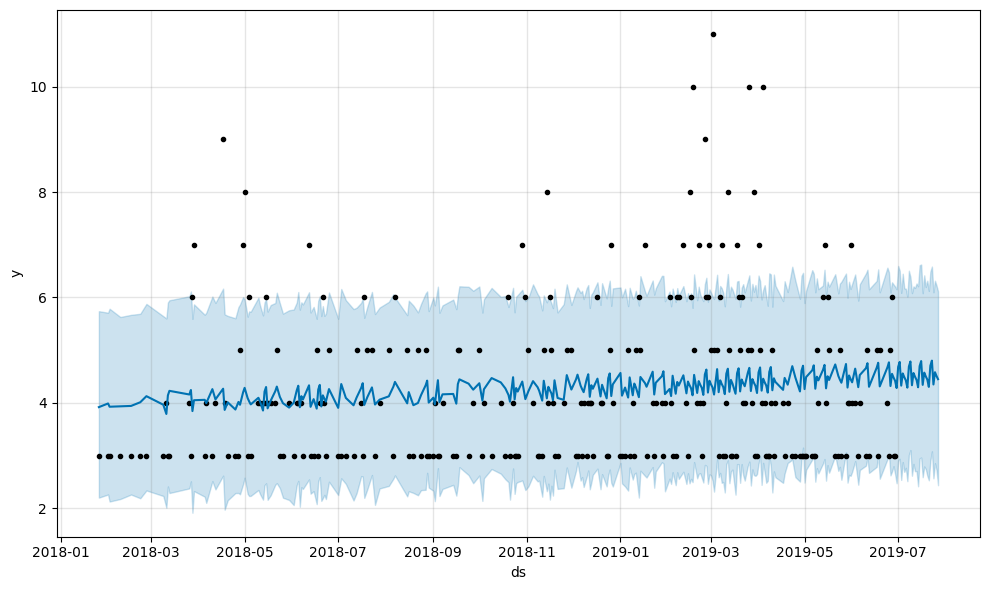

In [18]:
# Get the pickup location for the best model
sample_location_id = final_df.index[0]
print(f"sample location_id: {sample_location_id}")

# Get the model type
sample_model_type = final_df.loc[[sample_location_id]].model_type.values[0]
print(f"sample_model_type: {sample_model_type}")

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"type checkpoint: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()['model']
print(f"type restored model: {type(sample_model)}")

## OPTION 1 - Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()['forecast_df']
print(f"type restored df: {type(forecast_df)}")

# Print location and error.
sample_error =  final_df.loc[[sample_location_id]].error.values[0]
print(f"location {sample_location_id}, model_type {sample_model_type}, best error {sample_error}")

# If prophet model, use prophet built-in plot
if sample_model_type == 'arima':
    forecast_df.plot();
else:
#     # OPTION 2
#     # Create a forecast into the future
#     # Note: this is redundant work because we already did this during model training and eval
#     future_dates = sample_model.make_future_dataframe(periods=FORECAST_LENGTH, freq='D')
#     future = sample_model.predict(future_dates)
#     print("Tail of future dates:")
#     print(future_dates.tail())
    plot1 = sample_model.plot(forecast_df);

sample location_id: 237
sample_model_type: prophet_multiplicative
type restored model: <class 'prophet.forecaster.Prophet'>
type restored df: <class 'pandas.core.frame.DataFrame'>
location 237, model_type prophet_multiplicative, best error 1769.5216716829611


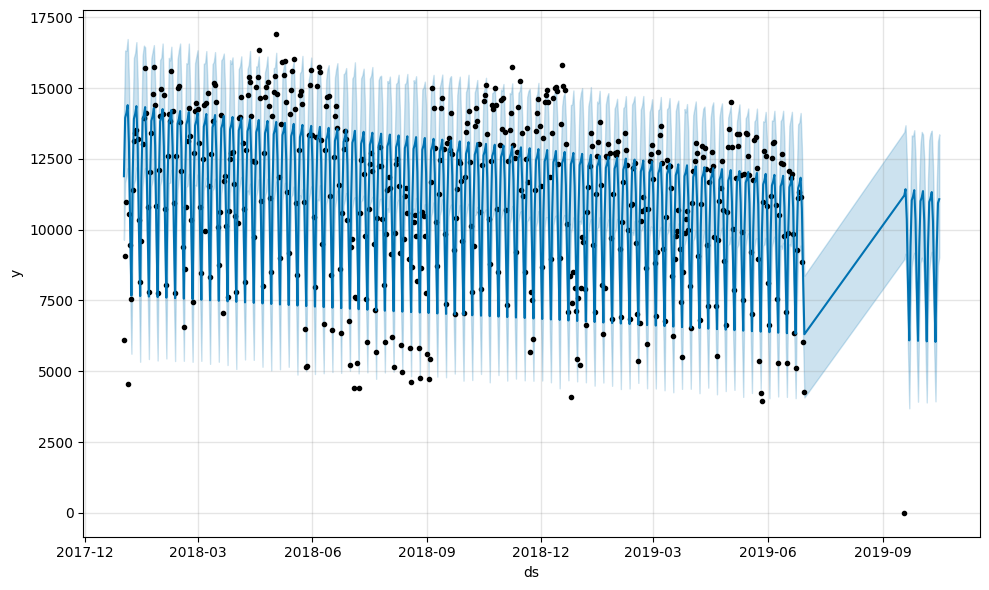

In [19]:
# Get the pickup location for the worst model
sample_location_id = final_df.index[len(final_df)-1]
print(f"sample location_id: {sample_location_id}")

# Get the model type
sample_model_type = final_df.loc[[sample_location_id]].model_type.values[0]
print(f"sample_model_type: {sample_model_type}")

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()['model']
print(f"type restored model: {type(sample_model)}")

## OPTION 1 - Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()['forecast_df']
print(f"type restored df: {type(forecast_df)}")

# Print location and error.
sample_error =  final_df.loc[[sample_location_id]].error.values[0]
print(f"location {sample_location_id}, model_type {sample_model_type}, best error {sample_error}")

# If prophet model, use prophet built-in plot
if sample_model_type == 'arima':
    forecast_df.plot();
else:
    plot1 = sample_model.plot(forecast_df);

In [ ]:
# Get the pickup location for an average model
sample_location_id = final_df.index[25]
print(f"sample location_id: {sample_location_id}")

# Get the model type
sample_model_type = final_df.loc[[sample_location_id]].model_type.values[0]
print(f"sample_model_type: {sample_model_type}")

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()['model']
print(f"type restored model: {type(sample_model)}")

## OPTION 1 - Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()['forecast_df']
print(f"type restored df: {type(forecast_df)}")

# Print location and error.
sample_error =  final_df.loc[[sample_location_id]].error.values[0]
print(f"location {sample_location_id}, model_type {sample_model_type}, best error {sample_error}")

# If prophet model, use prophet built-in plot
if sample_model_type == 'arima':
    forecast_df.plot();
else:
    plot1 = sample_model.plot(forecast_df);

sample location_id: 173
sample_model_type: arima
type restored model: <class 'pmdarima.arima.arima.ARIMA'>
type restored df: <class 'pandas.core.frame.DataFrame'>
location 173, model_type arima, best error 2.5616701162971762


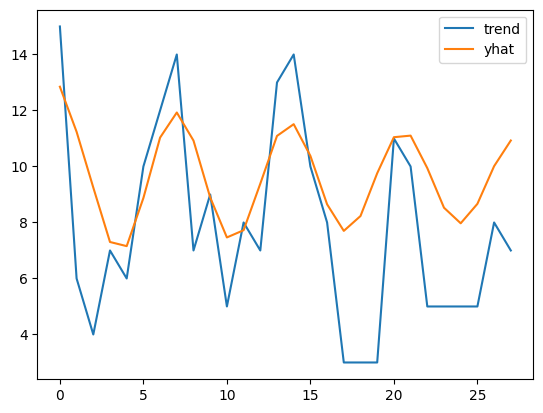

In [31]:
# Get the pickup location for an ARIMA model
sample_location_id = final_df.loc[(final_df.model_type=="arima"), :].sort_values("error").index.values[0]
print(f"sample location_id: {sample_location_id}")

# Get the model type
sample_model_type = final_df.loc[[sample_location_id]].model_type.values[0]
print(f"sample_model_type: {sample_model_type}")

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()['model']
print(f"type restored model: {type(sample_model)}")

## OPTION 1 - Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()['forecast_df']
print(f"type restored df: {type(forecast_df)}")

# Print location and error.
sample_error =  final_df.loc[[sample_location_id]].error.values[0]
print(f"location {sample_location_id}, model_type {sample_model_type}, best error {sample_error}")

# If prophet model, use prophet built-in plot
if sample_model_type == 'arima':
    forecast_df.plot();
else:
    plot1 = sample_model.plot(forecast_df);